# About the notebook

The code in the notebook aims to predict the price of bitcoin
after 3 minutes given the data of its price for the past 30 min. 
This is done by using a recurrent neural network. We can expect a 
low accuracy because of the variance of the dataset.

# Importing the needed libraries

In [102]:
import pandas as pd
from sklearn import preprocessing 
from collections import deque 
import random 
import numpy as np
import matplotlib.pyplot as plt 
import time
import matplotlib.pyplot as plt

import tensorflow 

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn


# Creating the dataset

In [64]:
df = pd.read_csv('BTC-USD.csv', names=['time', 'low', 'high', 'open', 'close', 'volume'])

In [65]:
df.head()

,time,low,high,open,close,volume
0,1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100
1,1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374
2,1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252
3,1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100
4,1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000


In [66]:
df.shape

(97724, 6)

Creating the future column 

In [67]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0
     

In [68]:
df['future'] = df['close'].shift(-3)    
df

,time,low,high,open,close,volume,future
0,1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100,6479.410156
1,1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374,6479.979980
2,1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252,6480.000000
3,1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100,6477.220215
4,1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000,6480.000000
...,...,...,...,...,...,...,...
97719,1535214960,6712.990234,6713.140137,6713.000000,6713.140137,0.769891,6715.000000
97720,1535215020,6713.339844,6715.000000,6715.000000,6714.520020,1.002652,6715.000000
97721,1535215080,6714.509766,6714.520020,6714.520020,6714.520020,1.021925,NaN
97722,1535215140,6714.520020,6715.000000,6714.520020,6715.000000,3.645508,NaN


## Creating the target data 

In [69]:
df['target'] = list(map(classify, df['close'], df['future']))
df

,time,low,high,open,close,volume,future,target
0,1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100,6479.410156,0
1,1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374,6479.979980,0
2,1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252,6480.000000,1
3,1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100,6477.220215,0
4,1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000,6480.000000,1
...,...,...,...,...,...,...,...,...
97719,1535214960,6712.990234,6713.140137,6713.000000,6713.140137,0.769891,6715.000000,1
97720,1535215020,6713.339844,6715.000000,6715.000000,6714.520020,1.002652,6715.000000,1
97721,1535215080,6714.509766,6714.520020,6714.520020,6714.520020,1.021925,NaN,0
97722,1535215140,6714.520020,6715.000000,6714.520020,6715.000000,3.645508,NaN,0


# Data preprocessing

 ## Normalizing and creating sequences for the data 

In [70]:
times = sorted(df.index.values)
last_5_pct = times[-int(len(times)*0.05)]

validation_df = df[(df.index >= last_5_pct)]
df = df[(df.index < last_5_pct)]

In [71]:
df.shape

(92838, 8)

In [72]:
validation_df.shape

(4886, 8)

Dropping all the missing values if any

In [73]:
df.isnull().sum()

time      0
low       0
high      0
open      0
close     0
volume    0
future    0
target    0
dtype: int64

No missing values so we continue

Function to help with the sequencues and balancing the data 

In [74]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect 
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict

def preprocessor(df):
    df = df.drop("future", 1)  

    for col in df.columns:  
        if col != "target":  # normalize all ... except for the target itself!
            df[col] = df[col].pct_change()  # pct change "normalizes" the different currencies 
            df.dropna(inplace=True)  
            df[col] = preprocessing.scale(df[col].values)  

    df.dropna(inplace=True)  # cleanup again just in case 


    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences

    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.asarray(X), y # return X and y...and make X a numpy array!



## Train and validation datasets 

In [57]:
X_train, y_train = preprocessor(df)
X_val, y_val = preprocessor(validation_df)


<ipython-input-56-f90b5829fcda>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("future", 1)
<ipython-input-56-f90b5829fcda>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("future", 1)


In [58]:
#cast y to numpy
y_train = np.array(y_train)
y_val = np.array(y_val)

# Creating the model

In [59]:
X_train.shape

(83160, 60, 6)

### RNN with a lot of params 

In [60]:
rnn1 = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True), #better stay in keras without use compact.v1
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.BatchNormalization(),

    tensorflow.keras.layers.LSTM(128, return_sequences=True),
    tensorflow.keras.layers.Dropout(0.1),
    tensorflow.keras.layers.BatchNormalization(),
    
    tensorflow.keras.layers.LSTM(128, return_sequences=True),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.BatchNormalization(),

    tensorflow.keras.layers.Dense(32, activation='relu'),
    tensorflow.keras.layers.Dropout(0.2),

    tensorflow.keras.layers.Dense(1, activation='sigmoid')

])

rnn1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 128)           69120     
                                                                 
 dropout_8 (Dropout)         (None, 60, 128)           0         
                                                                 
 batch_normalization_6 (Batc  (None, 60, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_9 (Dropout)         (None, 60, 128)           0         
                                                                 
 batch_normalization_7 (Batc  (None, 60, 128)          512       
 hNormalization)                                      

In [61]:

# Compile model
rnn1.compile(
    loss='mse', 
    optimizer='adam',
    metrics=['accuracy']
)

### RNN with less parameters 

In [85]:
rnn2 = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True), #better stay in keras without use compact.v1
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.BatchNormalization(),

    tensorflow.keras.layers.LSTM(64, return_sequences=True),
    tensorflow.keras.layers.Dropout(0.1),
    tensorflow.keras.layers.BatchNormalization(),
    
    tensorflow.keras.layers.LSTM(32, return_sequences=True),
    tensorflow.keras.layers.Dropout(0.1),
    tensorflow.keras.layers.BatchNormalization(),

    tensorflow.keras.layers.Dense(32, activation='relu'),
    tensorflow.keras.layers.Dropout(0.2),

    tensorflow.keras.layers.Dense(1, activation='sigmoid')

])

rnn2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 128)           69120     
                                                                 
 dropout_12 (Dropout)        (None, 60, 128)           0         
                                                                 
 batch_normalization_9 (Batc  (None, 60, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_10 (LSTM)              (None, 60, 64)            49408     
                                                                 
 dropout_13 (Dropout)        (None, 60, 64)            0         
                                                                 
 batch_normalization_10 (Bat  (None, 60, 64)           256       
 chNormalization)                                     

In [89]:
# Compile model
rnn2.compile(
    loss='mse', 
    optimizer='adam',
    metrics=['accuracy']
)

### RNN with less layers and less parameters 

In [91]:
rnn3 = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.LSTM(64, input_shape=(X_train.shape[1:]), return_sequences=True),
    tensorflow.keras.layers.Dropout(0.1),
    tensorflow.keras.layers.BatchNormalization(),
    
    tensorflow.keras.layers.LSTM(32, return_sequences=True),
    tensorflow.keras.layers.Dropout(0.1),
    tensorflow.keras.layers.BatchNormalization(),

    tensorflow.keras.layers.Dense(32, activation='relu'),
    tensorflow.keras.layers.Dropout(0.2),

    tensorflow.keras.layers.Dense(1, activation='sigmoid')

])

rnn3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 64)            18176     
                                                                 
 dropout_22 (Dropout)        (None, 60, 64)            0         
                                                                 
 batch_normalization_16 (Bat  (None, 60, 64)           256       
 chNormalization)                                                
                                                                 
 lstm_17 (LSTM)              (None, 60, 32)            12416     
                                                                 
 dropout_23 (Dropout)        (None, 60, 32)            0         
                                                                 
 batch_normalization_17 (Bat  (None, 60, 32)           128       
 chNormalization)                                     

In [92]:
# Compile model
rnn3.compile(
    loss='mse', 
    optimizer='adam',
    metrics=['accuracy']
)

# Training all the models 

### First model

In [84]:
history1 = rnn1.fit(
    X_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_val, y_val)
)


Epoch 1/10
1300/1300 [==============================] - 748s 567ms/step - loss: 0.2515 - accuracy: 0.4987 - val_loss: 0.2500 - val_accuracy: 0.4998
Epoch 2/10
1300/1300 [==============================] - 620s 477ms/step - loss: 0.2500 - accuracy: 0.4971 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 3/10
1300/1300 [==============================] - 607s 467ms/step - loss: 0.2500 - accuracy: 0.4984 - val_loss: 0.2500 - val_accuracy: 0.4999
Epoch 4/10
1300/1300 [==============================] - 616s 473ms/step - loss: 0.2500 - accuracy: 0.5003 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 5/10
1300/1300 [==============================] - 613s 471ms/step - loss: 0.2500 - accuracy: 0.5026 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 6/10
1300/1300 [==============================] - 615s 473ms/step - loss: 0.2500 - accuracy: 0.4993 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 7/10
1300/1300 [==============================] - 603s 464ms/step - loss: 0.2500 - accuracy: 0.4996 - val_

### Second model

In [97]:
history2 = rnn2.fit(
    X_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_val, y_val)
)


Epoch 1/10
1300/1300 [==============================] - 376s 282ms/step - loss: 0.2516 - accuracy: 0.5006 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 2/10
1300/1300 [==============================] - 360s 277ms/step - loss: 0.2500 - accuracy: 0.4975 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 3/10
1300/1300 [==============================] - 363s 279ms/step - loss: 0.2500 - accuracy: 0.5001 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 4/10
1300/1300 [==============================] - 365s 281ms/step - loss: 0.2500 - accuracy: 0.5015 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 5/10
1300/1300 [==============================] - 363s 279ms/step - loss: 0.2500 - accuracy: 0.4977 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 6/10
1300/1300 [==============================] - 365s 281ms/step - loss: 0.2500 - accuracy: 0.5007 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 7/10
1300/1300 [==============================] - 364s 280ms/step - loss: 0.2500 - accuracy: 0.5011 - val_

Third model

In [98]:
history3 = rnn3.fit(
    X_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_val, y_val)
)


Epoch 1/10
1300/1300 [==============================] - 142s 104ms/step - loss: 0.2515 - accuracy: 0.4994 - val_loss: 0.2502 - val_accuracy: 0.4999
Epoch 2/10
1300/1300 [==============================] - 135s 104ms/step - loss: 0.2501 - accuracy: 0.4999 - val_loss: 0.2501 - val_accuracy: 0.5001
Epoch 3/10
1300/1300 [==============================] - 138s 106ms/step - loss: 0.2500 - accuracy: 0.4994 - val_loss: 0.2500 - val_accuracy: 0.4996
Epoch 4/10
1300/1300 [==============================] - 135s 104ms/step - loss: 0.2500 - accuracy: 0.4980 - val_loss: 0.2500 - val_accuracy: 0.4998
Epoch 5/10
1300/1300 [==============================] - 134s 103ms/step - loss: 0.2500 - accuracy: 0.4996 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 6/10
1300/1300 [==============================] - 136s 105ms/step - loss: 0.2500 - accuracy: 0.4997 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 7/10
1300/1300 [==============================] - 135s 104ms/step - loss: 0.2500 - accuracy: 0.4974 - val_

#Evaluation 

First model

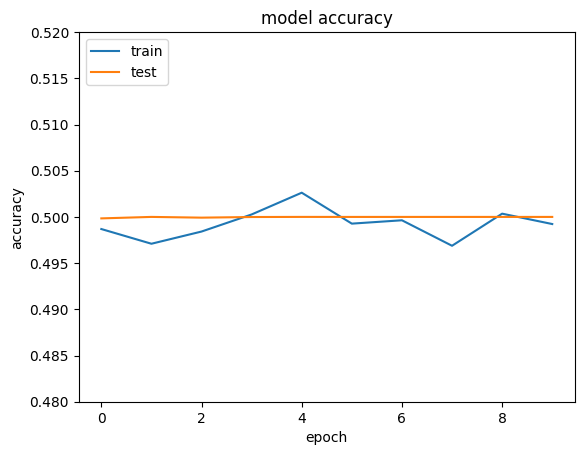

In [121]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylim([0.48, 0.52])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Second model

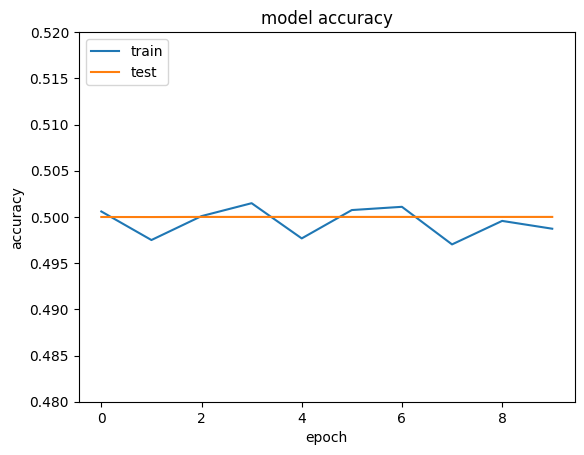

In [120]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylim([0.48, 0.52])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Third model

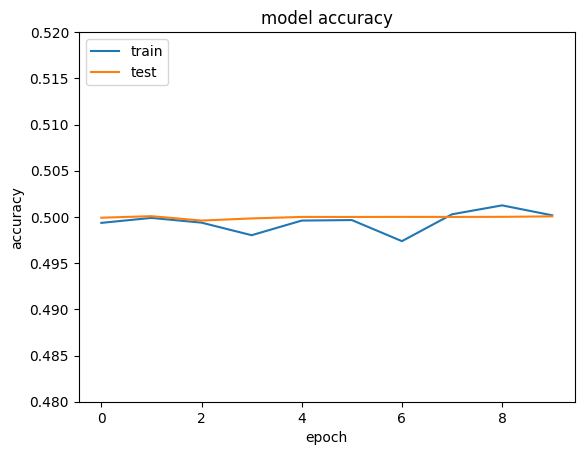

In [119]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylim([0.48, 0.52])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Comparing the accuracies of each model

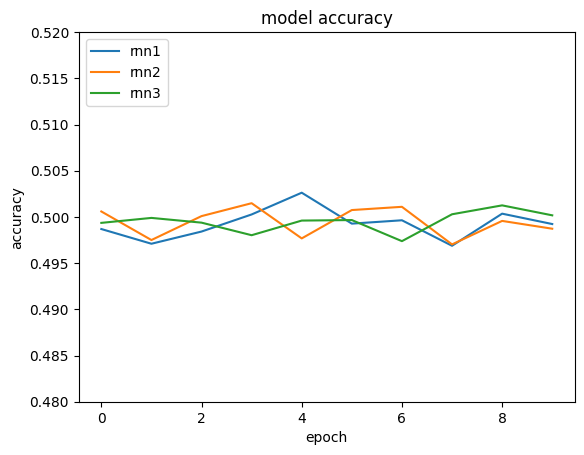

In [118]:
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.ylim([0.48, 0.52])
plt.title('model accuracy')
plt.ylabel('accuracy', )
plt.xlabel('epoch')
plt.legend(['rnn1', 'rnn2', 'rnn3'], loc='upper left')
plt.show()

# Conclusion

All the models are converging pretty well and none of them is overfitting or underfitting. We can see some slightly better performance on the second model which has less parameters and less layers than the first model. We can say that a large number of layers and parameters doesnt necessary mean better accuracy. In this case the model with less than half the parameters was more accurate, more efficient and less expensive to run.